# Spot the spots

## Introduction to Machine Learning on NeSI Workshop

This notebook shows how machine learning can be applied to feature detection. You're faced with the tedious task of counting "spots" present in a large number of data samples. The spots may represent pictures of fishes, tropical cyclones, skin moles, tumours or black holes - you choose.

*You want to hand over the task to a machine so you can spend more time relaxing with friends, family or at the beach.*

## Requirements

You will need:
    
 * Python 3
 * NumPy
 * Matplotlib
 * TensorFlow 2.0

## Input parameters for the dataset

In [1]:
# dataset input values - feel free to change
numTrain = 1000    # number of training samples
numTest = 100      # number of testing samples
numCells = 40      # the data have size numCells x numCells
maxNumSpots = 5    # the maximum number of spots 0...maxNumSpots

## Reproducible results for testing the model

Setting the random seeds ensures you will get the same results when running this notebook from the start (Restart and Run All). Feel free change the seed value or comment out this block to test your model on different data.

In [2]:
random_seed = 123

import numpy as np
np.random.seed(random_seed)

import tensorflow as tf
tf.random.set_seed(random_seed)

import random
random.seed(random_seed)

## Where the code will run

Uncomment these commands to show what devices are available and are being used.

In [3]:
# list available GPUs
#tf.config.experimental.list_physical_devices()

In [4]:
# print info about which device operations are running on
#tf.debugging.set_log_device_placement(True)

## Some convenience functions

### Function to generate random samples

This function generates 2D images/data with spots at random locations, well inside the data. A spot is a Gaussian field. Spots can be on top of each other, i.e. partially obstruct each other. The sample data are normalised to be between 0 and 1.

In [5]:
# define the 2d grid
xs = np.linspace(0., 1., numCells)
ys = np.linspace(0., 1., numCells)
xxs, yys = np.meshgrid(xs, ys)

def generateRandomSamples(numSamples):
    """
    Generate samples containing random data with spots (Gaussian field over zero background)
    @param numSamples number of samples to generate
    @return samplesInput array containing data for the samples
    @return samplesOutput vector with the correct number of spots in each sample
    
    """
    # allocate memory
    samplesInput = np.zeros((numSamples, numCells, numCells), np.float32)
    samplesOutput = np.zeros((numSamples,), np.int8)
    # create the samples
    for sample in range(numSamples):
        numSpots = int(maxNumSpots * np.random.random() + 0.5)
        data = samplesInput[sample, ...]
        for i in range(numSpots):
            # random radius
            rad = 0.1 + 0.0*np.random.random()  # currently fixed radius of 0.1
            # random location
            x0, y0 = 0.1 + 0.8*np.random.random(), 0.1 + 0.8*np.random.random()
            data += np.exp( -((xxs - x0)**2 + (yys - y0)**2)/rad**2 )
        # normalize, filter nans
        maxVal = data.max()
        if maxVal != 0:
            data /= maxVal
        data = np.nan_to_num(data)
        samplesOutput[sample] = numSpots
  
    return samplesInput, samplesOutput

### Function to plot the data

In [6]:
import matplotlib.pylab as plt

numCols = 5
def plotData(iBeg, iEnd, dataInput, dataOutput, dataReferenceOutput=[]):
    """
    Plot the data
    @param iBeg start index in the dataset (list of 2D data)
    @param iEnd one past the last index in the dataset
    @param dataInput dataset
    @param dataOutput number of spots for each data array
    @param dataReferenceOutput correct number of spots for each data array
  
    """
    numPlots = iEnd - iBeg
    numRows = numPlots // numCols
    if numPlots % numCols > 0:
        numRows += 1
    for i in range(iBeg, iEnd):
        plt.subplot(numRows, numCols, i - iBeg + 1)
        plt.imshow(dataInput[i, ...], cmap='YlOrBr')
        plt.axis('off')
        txt = '{:.1f}'.format(dataOutput[i])
        if len(dataReferenceOutput) > 0:
            txt += ' ({})'.format(dataReferenceOutput[i])
        plt.title(txt, fontsize=8)
    plt.show()

## 1. Create the training data

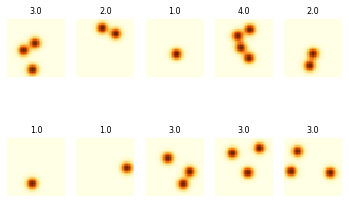

In [7]:
trainInput, trainOutput = generateRandomSamples(numTrain)
plotData(0, min(10, numTrain), trainInput, trainOutput)  # plotting a subset of the training dataset

## 2. Create the test data

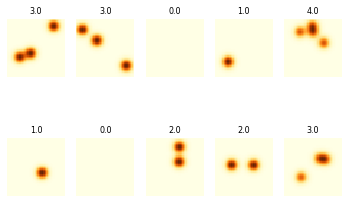

In [8]:
testInput, testOutput = generateRandomSamples(numTest)
plotData(0, min(10, numTest), testInput, testOutput)  # plotting a subset of the testing dataset

## 3. Creating the neural network

We use Keras, a user friendly interface to TensorFlow and other tools. Below is one possible setup to solve our feature extraction problem -- feel free to play with the number of epochs, layers, filters, etc. Those feeling adventurous may want to try different layouts.

Because our problem involves pattern recognition, we start by building a convolution neural network. The neural network architecture consists of three groups of layers.

The 2D convolution layer applies different, 3x3 filters across the sample data. Each of the filters is trained to identify different patterns. The max pooling layer fires up a signal to the next level whenever there is a good match between a data region and the filter. 

The first pair of Conv2D/MaxPooling2D layers looks for patterns at the finest granularity. The next pair of Conv2D/MaxPooling2D layers searchs for patterns at coarser resolution. The patterns at high and low resolution might be different.

The second pair of Conv2D/MaxPooling2D layers feeds into a dense layer, which combines all the outputs of coarse filters shifted across the data to produce a single number representing the number of spots. That dense layer is equivalent to performing a linear regression. The output of the dense layer is a floating point number, like 3.2. We then round this number to the nearest integer to infer the number of spots (3).

In [10]:
from tensorflow import keras

# build the neural network
model = keras.Sequential()

# first layer - looking at fine details
model.add( keras.layers.Conv2D(8, kernel_size=(3,3), strides=(1,1),
                             padding='same', data_format='channels_last',
                             activation='relu', input_shape=(numCells, numCells, 1)) )
model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)) )

# second layer - looking at coarser details...
model.add( keras.layers.Conv2D(8, kernel_size=(3,3), strides=(1,1),
                             padding='same', data_format='channels_last',
                             activation='relu') )
model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)) )

# add a dense layer with linear regression
model.add( keras.layers.Flatten() )
model.add( keras.layers.Dense(1) )

# configure the model for training
model.compile(optimizer='adam', loss='mean_squared_error',
              metrics=['accuracy'])

# give a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 40, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 801       
Total params: 1,465
Trainable params: 1,465
Non-trainable params: 0
______________________________________________________

## 4. Train the neural network

The input is a 4d tensor which should have shape (samples, rows, cols, channels) since we specified "channels_last" as the data format above. Thus we have to reshape our 3d array to add a channel dimension.

In [11]:
numEpochs = 10
history = model.fit(trainInput.reshape(-1, numCells, numCells, 1),
                    trainOutput, epochs=numEpochs, validation_split = 0.3)

Train on 700 samples, validate on 300 samples
Epoch 1/10
700/700 [==============================] - 2s 4ms/sample - loss: 4.5501 - accuracy: 0.1729 - val_loss: 0.6553 - val_accuracy: 0.2133
Epoch 2/10
700/700 [==============================] - 0s 192us/sample - loss: 0.8682 - accuracy: 0.2000 - val_loss: 0.6421 - val_accuracy: 0.2133
Epoch 3/10
700/700 [==============================] - 0s 193us/sample - loss: 0.6247 - accuracy: 0.2000 - val_loss: 0.4811 - val_accuracy: 0.2133
Epoch 4/10
700/700 [==============================] - 0s 193us/sample - loss: 0.5342 - accuracy: 0.2671 - val_loss: 0.4259 - val_accuracy: 0.3200
Epoch 5/10
700/700 [==============================] - 0s 195us/sample - loss: 0.4999 - accuracy: 0.3014 - val_loss: 0.4069 - val_accuracy: 0.3200
Epoch 6/10
700/700 [==============================] - 0s 194us/sample - loss: 0.4778 - accuracy: 0.3014 - val_loss: 0.3903 - val_accuracy: 0.3200
Epoch 7/10
700/700 [==============================] - 0s 201us/sample - loss: 0.

### Plotting the model performance

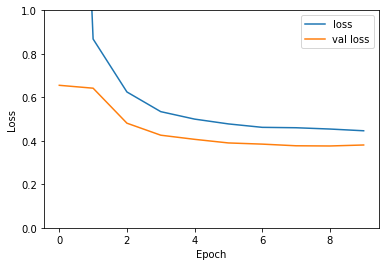

In [12]:
# plot the loss against epoch
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='best')
plt.show()

## 5. Determine the accuracy of the model using the training data

In [13]:
predictions = model.predict(testInput.reshape(-1, numCells, numCells, 1))[:, 0]
# compute the errors: difference between predictions and testOuput
errors = np.round(predictions) - testOutput
numErrors = (errors != 0).sum()
print(errors)
print(f'num errors = {numErrors} ({100*numErrors/numTest} %)')
# could use f'{numErrors}'

[ 0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  1.  0.
  0.  0.  0.  0.  0.  1.  0. -1.  0.  0.  0.  0.  0. -1.  0.  0.  0.  1.
  0.  0. -1.  0. -1.  0.  0. -2.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0. -1.  0.  0. -2. -1.  0.  0. -1. -1.  0. -1.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0. -1.  0.
  0. -2.  0.  0. -1.  0. -1.  0. -1.  0.]
num errors = 26 (26.0 %)



Plotting datasets for which the predictions were wrong

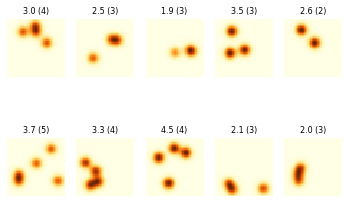

In [14]:
inds = np.nonzero(errors != 0)[0]
failuresInput = testInput[inds, :]
failuresOutput = predictions[inds]
correctOutput = testOutput[inds]
numFailures = len(failuresOutput)
plotData(0, min(10, numFailures), failuresInput, failuresOutput, correctOutput)

## Exercises / Questions to think about

1. Does the neural network tend to over or under predict the number of spots?
2. What is the most common reason of failure to predict the correct number of spots?
3. List the parameters that can likely improve the predictions
4. Try to improve the accuracy of the predictions - feel free to change anything above, such as:
   * parameters for the layers (convolution, pooling, dense - see for example the [convolution layers documentation](https://keras.io/layers/convolutional/))
     - number of filters, kernel size, stride, etc.
   * add or remove layers (e.g. convolution, pooling, dense layers)
   * adjust other parameters, e.g. the size of the input dataset

Remember to restart the kernel and run from the beginning to make it reproducible.

See if you can reduce the error.

If you manage to improve your model, try changing/removing the random seed and see if the behaviour changes.

If you find a better solution, let us know so we can add it to the notebook!